# Sample for myGA based on optimizing heating rod design variables

In [1]:
#This is the simulation function, The module use in the calculation must be import in the function if you intended to run it parallelly, since a new python process is spawned and need to load the module separately from the main process.

def simulate_1D_Heat_optimization_warper(_k, _delta):
    import numpy as np
    import scipy.sparse as sparse

    # Constant Parameters
    a = 0.9                         #[unitless] / Joule heating absorption coefficient
    C = 1000                        #[J/(kg K)] / heat capacity
    delta = _delta                   #non zero boundary flux
    epsilon = 100                   #[V/m]      / Magnitude of imposed elctric field
    sigmaC = 5e5                    #[S/m]      / isotropic electrical conductivity
    J = sigmaC*epsilon              #[A/m**2]   / Magnitude of electrical current density
    K = _k                         #[W/(m*K)]  / sotropic thermal conductivity
    L = 0.01                        #[m]        / domain length
    N_x = np.array([2,10,20])       #[unitless] / number of domain discretization
    rho = 6000                      #[kg/m**3]  / material density
    T = 1                           #[s]        / Simulation time
    dt = 1e-5                       #[s]        / timestepsize
    # dx = L/N_x 

    #initial values
    theta_init = 300                #[K]        / initial temperature

    debug_flag = True

    def construct_helper_Matrices(_L, _N_x,_dt, _LH_BC_type: str, _RH_BC_type: str, _LH_BC_flux: float = 0.0, _RH_BC_flux: float = 0.0, forced: bool = False, debug:bool = False):
        #This function create conductive matrix ndd force helper vector for iterattion
        # it return conductive andd force helper matrices in scipy's sparse format
        _dx = _L/_N_x
        
        if forced:
            _force_term = (a*J*epsilon*_dt)/(rho*C)
        else:
            _force_term = 0
        if debug:
            print("force_term = ", _force_term)
        
        _conductive_term = (K*_dt)/(rho*C*_dx**2)
        
        #helper function and constant to generate dirichlet and neumann BC row
        dirichlet_conduction_row = sparse.coo_array((1,_N_x+1),dtype=float)
        dirichlet_force_elem = 0
        if debug:
            print("dirichlet_conduction_row = ", dirichlet_conduction_row.toarray())
    
        def neumann_Mat (_side:str, _flux:float = 0.0):
            _conduction_row = np.zeros(_N_x+1)
            if _side == "left":
                _conduction_row[:2] = np.array([-_conductive_term, _conductive_term]) #not used, need to recheck
                _force_elem = (_RH_BC_flux*_dx/K)*_conductive_term +_force_term
            if _side == "right":
                _conduction_row[-2:] = np.array([_conductive_term, -_conductive_term])
                _force_elem = (_RH_BC_flux*_dx/K)*_conductive_term +_force_term
            _conduction_row = sparse.coo_array(_conduction_row)
            return _conduction_row, _force_elem
        
        #create the middle part of the convective helper matrix
        ex = _conductive_term*np.ones(_N_x+1)
        convective_multipliers = np.array([ex, -2*ex, ex])
        offsets = np.array([0,1,2])    
        _conduction_Mat = sparse.dia_array((convective_multipliers, offsets), shape=(_N_x-1, _N_x+1))

        #create the middle part of the convective helper vector
        _force_vec = _force_term*np.ones(_N_x-1)
        if debug:
            print("conduction_Mat (Middle Part) = ")
            print(_conduction_Mat.toarray())
            print("force_vec (Middle Part) = ", _force_vec)

        #create the first row of convective helper matrix according to LH BC
        if _LH_BC_type == "dirichlet":
            _conduction_Mat = sparse.vstack([dirichlet_conduction_row,_conduction_Mat])
            _force_vec = np.insert(_force_vec, 0, dirichlet_force_elem)
        if _LH_BC_type == "neumann":
            _LH_conduction_row, _LH_force_elem = neumann_Mat (_side= "left", _flux = _LH_BC_flux)
            _conduction_Mat = sparse.vstack([_LH_conduction_row,_conduction_Mat])
            _force_vec = np.insert(_force_vec, 0, _LH_force_elem)
        
        if debug:
            print("conduction_Mat (with LHBC) = ")
            print(_conduction_Mat.toarray())
            print("force_vec (with LHBC) = ", _force_vec)

        #create the last row of convective helper matrix according to RH BC
        if _RH_BC_type == "dirichlet":
            _conduction_Mat = sparse.vstack([_conduction_Mat, dirichlet_conduction_row])
            _force_vec = np.append(_force_vec, dirichlet_force_elem)
        if _RH_BC_type == "neumann":
            _RH_conduction_row, _RH_force_elem = neumann_Mat (_side= "right", _flux = _RH_BC_flux)
            if debug:
                print("_RH_conduction_row = ")
                print(_RH_conduction_row.toarray())
                print("_RH_force_elem = ", _RH_force_elem)
            _conduction_Mat = sparse.vstack([_conduction_Mat,_RH_conduction_row])
            _force_vec = np.append(_force_vec,_RH_force_elem)
        
        _conduction_Mat = _conduction_Mat + sparse.identity(_N_x+1)
        _force_vec = sparse.coo_array(_force_vec)
        
        if debug:
            print("conduction_Mat (final) = ")
            print(_conduction_Mat.toarray())
            print("force_vec (final) = ", _force_vec.toarray())

        return _conduction_Mat, _force_vec
    
    def profile(x):
        return theta_init
    
    vectorized_init_profile = np.vectorize(profile)
    
    def simulate(_L,_N_x, _T, _dt, _initial_profile:callable, _LH_BC_type: str, _RH_BC_type: str, _LH_BC_temp: float = 0.0, _RH_BC_temp: float = 0.0, _LH_BC_flux: float = 0.0, _RH_BC_flux: float = 0.0, forced: bool = False, debug:bool = False):
        #This function generate initial temperature profile, helper matrices then simulate Joule Heating
        #Inputs:
        #initial profile: np vectorized function accepting array of x as input.

        _x_arr,_dx = np.linspace(0,_L,int(_N_x+1),retstep=True) #discrete x and discretized x size
        _N_t = int(_T/_dt)
        
        #Temperature profile
        theta = np.zeros((_N_t+1,_N_x+1))

        #initial temperature profile
        theta[0,:] = _initial_profile(_x_arr)

        if _LH_BC_type == "dirichlet":
            theta[0,0] = _LH_BC_temp
        if _RH_BC_type == "dirichlet":
            theta[0,-1] = _RH_BC_temp

        #Create helper matrices
        _conduction_Mat, _force_vec = construct_helper_Matrices(_L, _N_x,_dt, _LH_BC_type, _RH_BC_type, _LH_BC_flux, _RH_BC_flux, forced, debug)

        #start simulation
        step = 1
        while step <  _N_t+1:
            results = _conduction_Mat@theta[step-1,:] + _force_vec
            theta[step,:] = results
            #Applying BC
            if _LH_BC_type == "dirichlet":
                pass 
            if _LH_BC_type == "neumann":
                results[0,0] = results[0,1] - (_LH_BC_flux*_dx)/K

            if _RH_BC_type == "dirichlet":
                pass
            if _RH_BC_type == "neumann":
                results[-1,-1] = results[-1,-2] + (_RH_BC_flux*_dx)/K
                step+=1
        return theta,_x_arr
    
    #Start simulation
    theta,x_arr = simulate(L,N_x[2], T, dt, vectorized_init_profile, _LH_BC_type = "dirichlet", _RH_BC_type = "neumann",  _LH_BC_temp = theta_init, _RH_BC_temp = theta_init, _LH_BC_flux = 0.0, _RH_BC_flux = delta, forced = True, debug = False)
    theta_max = np.max(theta[-1,:])
    theta_right = theta[-1,-1]
    return theta_max, theta_right


In [2]:
from myGA import myGA

#Optimization constant Parameter
K = 10                          #[unitless] / Number of offspring
P = 10                          #[unitless] / Number of Parents
S = 30                          #[unitless] / Number of design strings in a population
G = 20                          #[1/K]      / max number of generations
costTOL = 1e-7                  #[unitless] / acceptable cost function threshold to stop evolution
theta_des1 = 495                #[K] / desired peak temperature across the bar at time t = T
theta_des2 = 460                #[K] / desired temperature at x = L at time t = T
w1 = 1000                       #[unitless] / weight 1 for cost function
w2 = 1000                       #[unitless] /weight 2 for cost function
K_L = 450                       #[unitless] /lower search bound for K
K_U = 650                      #[unitless] /upper search bound for K
delta_L = -2e7                     #[A/m**2]   /lower search bound for delta
delta_U = -1e7                   #[A/m**2]   /upper search bound for delta

#Objective functions
def objective_function(theta_max, theta_right):
    theta_des1 = 495                #[K] / desired peak temperature across the bar at time t = T
    theta_des2 = 460                #[K] / desired temperature at x = L at time t = T
    w1 = 1000                       #[unitless] / weight 1 for cost function
    w2 = 1000                       #[unitless] /weight 2 for cost function
    return w1*((abs(theta_max-theta_des1)/theta_des1)**3)+w2*((abs(theta_right-theta_des2)/theta_des2)**3)

In [3]:
optimizer_parallel_sim_parallel_cost = myGA(maxGen= G, numString= S, numParent= P, numOffspring= K, TOL= costTOL, num_continuous_dv=2, mutate_continuous_dv=True, procFunction= simulate_1D_Heat_optimization_warper, objFunction= objective_function, varMax=[K_U,delta_U], varMin=[K_L,delta_L],parallel_simulation= True,parallel_cost= False)

In [4]:
optimizer_parallel_sim_parallel_cost.run()

Generation no: 0
This generation pi_min = 0.0061378108498940116
This generation pi_avg = 2.3973216234441592
Generation no: 1
This generation pi_min = 0.0061378108498940116
This generation pi_avg = 1.0211193986845681
Generation no: 2
This generation pi_min = 0.0061378108498940116
This generation pi_avg = 0.4255400823804011
Generation no: 3
This generation pi_min = 0.0027049688164663744
This generation pi_avg = 0.9736140344327564
Generation no: 4
This generation pi_min = 0.0027049688164663744
This generation pi_avg = 1.480617993077029
Generation no: 5
This generation pi_min = 0.0027049688164663744
This generation pi_avg = 1.209339937980078
Generation no: 6
This generation pi_min = 0.0008165864729552653
This generation pi_avg = 1.68439299140064
Generation no: 7
This generation pi_min = 0.0008165864729552653
This generation pi_avg = 1.3205444868637461
Generation no: 8
This generation pi_min = 0.0008165864729552653
This generation pi_avg = 0.8122557967336352
Generation no: 9
This generation

c:\Users\booms\C201_Modeling_Simulation\myGeneticAlgorithm\myGA.py:275: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


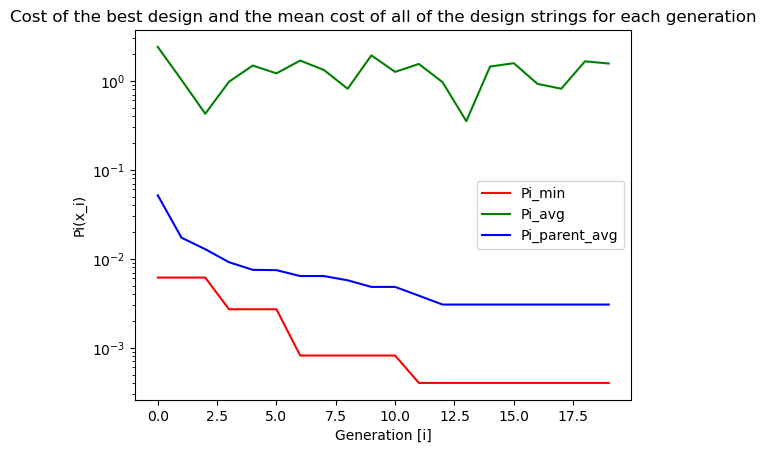

In [5]:
optimizer_parallel_sim_parallel_cost.plot_Pi()

In [6]:
optimizer_parallel_sim_parallel_cost.Lambda

[Design_string(continuous_dv_list=[509.38256620021167, -13894429.86080825], custom_dv_list=[]),
 Design_string(continuous_dv_list=[499.956852427849, -13876610.979446936], custom_dv_list=[]),
 Design_string(continuous_dv_list=[573.1813137348873, -12970501.98281752], custom_dv_list=[]),
 Design_string(continuous_dv_list=[496.02555201552246, -13851840.078064997], custom_dv_list=[]),
 Design_string(continuous_dv_list=[554.4226876472558, -13506382.73040008], custom_dv_list=[]),
 Design_string(continuous_dv_list=[492.97685742687037, -13788582.571903873], custom_dv_list=[]),
 Design_string(continuous_dv_list=[559.9193493334219, -12721928.759680651], custom_dv_list=[]),
 Design_string(continuous_dv_list=[584.8243217910494, -13079116.108939994], custom_dv_list=[]),
 Design_string(continuous_dv_list=[482.69443581780524, -13859430.49497572], custom_dv_list=[]),
 Design_string(continuous_dv_list=[484.9342741883, -14419488.728634102], custom_dv_list=[]),
 Design_string(continuous_dv_list=[482.70832

In [18]:
top4 = optimizer_parallel_sim_parallel_cost.Lambda[0:4]
top4

[Design_string(continuous_dv_list=[530.5099126115335, -13518630.054753432], custom_dv_list=[]),
 Design_string(continuous_dv_list=[529.1885344622777, -13400075.586162567], custom_dv_list=[]),
 Design_string(continuous_dv_list=[559.0982830715501, -13047722.745842177], custom_dv_list=[]),
 Design_string(continuous_dv_list=[550.4515749193067, -13352026.49849866], custom_dv_list=[])]